In [71]:
import numpy as np
import json
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.stats import lognorm, pearsonr

from copy import deepcopy
import time
from datetime import timedelta

# Import Data

In [72]:
edges = {}
counter = 0
with open('congress.edgelist') as reader:
    line = reader.readline()
    while line != '':
        obj = line.split(' ')
        edge_l = int(obj[0])
        edge_r = int(obj[1])

        if edge_l not in edges:
            edges[edge_l] = [edge_r]
        else:
            edges[edge_l].append(edge_r)
        counter += 1
        line = reader.readline()

num_nodes = len(edges.keys())

print(f"Total Edges Found: {counter}")

Total Edges Found: 13289


In [73]:
import json
json_str = json.dumps(edges)
with open("Albright_Edgelist.json", "w") as text_file:
    text_file.write(json_str)

# Pagerank Algorithm

In [74]:
def pagerank(e: dict, a: float = 0.85, num_iters: int = 10) -> dict:
    """This computes the PageRank algorithm using an inputed edge list and a given alpha

    Args:
        e (dict): Key: node, Value: list of edges
        a (float): Alpha modifier

    Returns:
        dict: Key: node, Value: Pagerank score (float)
    """
    assert a >= 0 and a < 1, "Alpha must be between [0,1)"

    node_names = set([a for a in e.keys()])
    num_nodes = len(node_names)
    init_value = 1 / num_nodes
    values = [init_value] * num_nodes
    pageranks = dict(zip(node_names, values))
    global_offset = (1 - a)/num_nodes

    def pr(edge) -> float:
        sum = 0
        for k in e[edge]:
            pr_k = pageranks[k]
            c_k = len(edges[k])
            sum += pr_k/c_k

        return global_offset + a*sum
    
    start_time = time.perf_counter()
    for i in range(num_iters):
        new_pageranks = {}
        for edge in node_names:
            new_pageranks[edge] = pr(edge)
        pageranks = deepcopy(new_pageranks)
        
    duration = timedelta(seconds=time.perf_counter()-start_time)
    print(f"Total Time Took: {duration}")
    print(f"Average Time Took: {(duration/num_iters)}")
    return pageranks 

calculated_pagerank = pagerank(edges, 0.85, 100)

Total Time Took: 0:00:00.107594
Average Time Took: 0:00:00.001076


# HITS Algorithm

In [75]:
def HITS(e: dict, num_iters: int = 10) -> tuple[dict, dict]:
    """Computes the HITS algorithm and returns the hub/authority scores of all the nodes.

    Args:
        e (dict): Key: Node, Value: Array of nodes k that k points to (out).
        num_iters (int, optional): Amount of times to loop. Defaults to 10.

    Returns:
        tuple[dict, dict]: Hub, Authority
    """
    node_names = set([a for a in e.keys()])
    num_nodes = len(node_names)
    init_value = 1
    values = [init_value] * num_nodes
    hub = dict(zip(node_names, values))
    aut = dict(zip(node_names, values))

    out_nodes = e
    in_nodes = dict(zip(node_names, [[] for i in range(num_nodes)]))
    for node in node_names:
        nodes_pointing_to = out_nodes[node]
        for node_destination in nodes_pointing_to:
            in_nodes[node_destination] = in_nodes[node_destination] + [node]

    def calc_hub(edge) -> float:
        sum = 0.0
        for n in in_nodes[edge]:
            sum += aut[n]
        return sum
    
    def calc_authority(edge) -> float:
        sum = 0.0
        for n in out_nodes[edge]:
            sum += hub[n]
        return sum
    
    def norm_dict(d: dict) -> dict:
        sum = 0
        for k in d.keys():
            sum += d[k]
        for k in d.keys():
            d[k] = d[k]/sum
        return d
    
    start_time = time.perf_counter()
    for i in range(num_iters):
        init_value = 1
        values = [init_value] * num_nodes
        new_aut = dict(zip(node_names, values))
        new_hub = dict(zip(node_names, values))

        for edge in node_names:
            new_hub[edge] = calc_hub(edge)
            new_aut[edge] = calc_authority(edge)
        
        new_hub = norm_dict(new_hub)
        new_aut = norm_dict(new_aut)

        hub = deepcopy(new_hub)
        aut = deepcopy(new_aut)

    duration = timedelta(seconds=time.perf_counter()-start_time)
    print(f"Total Time Took: {duration}")
    print(f"Average Time Took: {(duration/num_iters)}")
    return hub, aut 

calculated_Hub, calculated_Authority = HITS(edges, 1)

Total Time Took: 0:00:00.001269
Average Time Took: 0:00:00.001269


## HITS Score Distribution

In [76]:
hub_data = [calculated_Hub[h] for h in calculated_Hub.keys()]
aut_data = [calculated_Authority[h] for h in calculated_Authority.keys()]

### Histogram

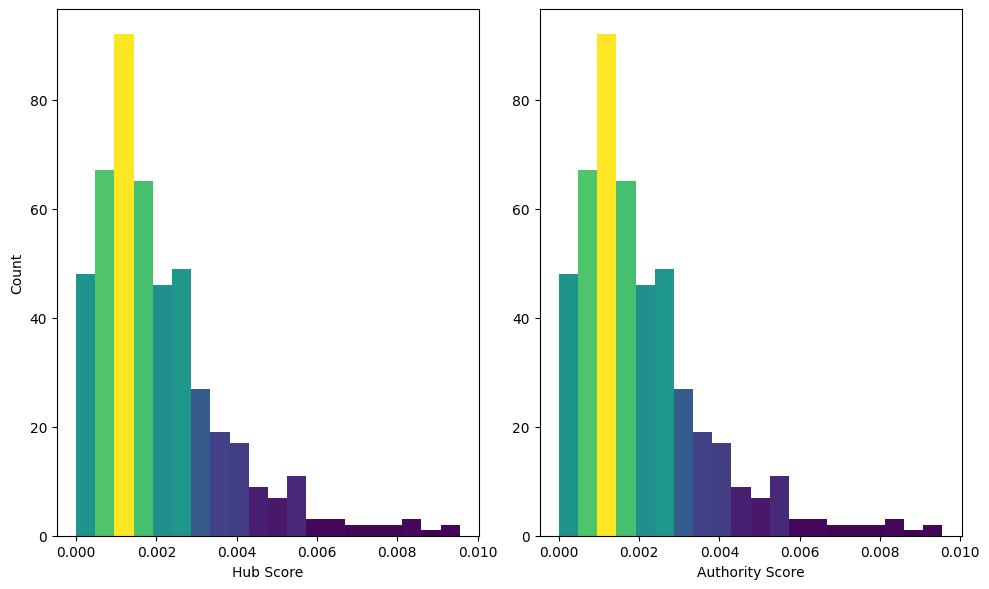

In [77]:
# NOTE: this was essential copy and paste from matplotlib's docs.
# https://matplotlib.org/stable/gallery/statistics/hist.html#sphx-glr-gallery-statistics-hist-py
n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(hub_data, bins=n_bins)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[1].hist(hub_data, bins=n_bins)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Set Labels
axs[0].set_xlabel("Hub Score")
axs[1].set_xlabel("Authority Score")
axs[0].set_ylabel("Count")
fig.set_size_inches(10, 6)

### 2D-Histogram with both Hub and Authority

Text(0, 0.5, 'Authority Score')

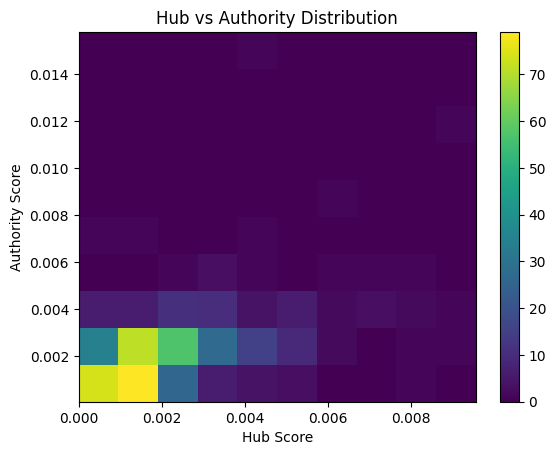

In [78]:
# fig, ax = plt.subplots(tight_layout=True)
# hist = ax.hist2d(hub_data, aut_data)
plt.hist2d(hub_data, aut_data)
plt.colorbar()
plt.title("Hub vs Authority Distribution")
plt.xlabel("Hub Score")
plt.ylabel("Authority Score")

# Pearson's Correlation Coefficient: Hub vs Pagerank

In [79]:
hub_data = []
auth_data = []
pr_data = []
for node in edges.keys():
    hub_data.append(calculated_Hub[node])
    auth_data.append(calculated_Authority[node])
    pr_data.append(calculated_pagerank[node])

In [83]:
print(f"Hub vs Pagerank: {pearsonr(hub_data, pr_data).statistic}")
print(f"Pagerank vs Hub: {pearsonr(pr_data, hub_data).statistic}")

Hub vs Pagerank: 0.4785404724621462
Pagerank vs Hub: 0.4785404724621462


# Pearson's Correlation Coefficient: Authority vs Pagerank

In [84]:
print(f"Authority vs Pagerank: {pearsonr(auth_data, pr_data).statistic}")
print(f"Pagerank vs Authority: {pearsonr(pr_data, auth_data).statistic}")

Authority vs Pagerank: 0.9991239900382854
Pagerank vs Authority: 0.9991239900382854
